In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, digamma, softmax

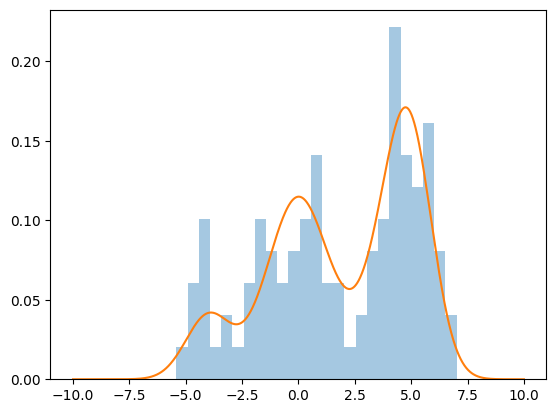

In [ ]:
N = 100

pesos = np.array([0.1, 0.4, 0.2, 0.3])
medias = np.array([-4, 0, 4, 5])
var = np.array([1, 1.94, 1.44, 1])

clase = np.random.choice(4, size=N, p=pesos)
data = np.zeros(N)
i = 0
for k in clase:
  data[i] = np.random.normal(medias[k], np.sqrt(var[k]))
  i += 1

plt.hist(data, bins=25, density=True, alpha=0.4)

data = data.reshape(N, 1)

#Para graficar la densidad

def norm_pdf(x, mu, sigma):
  return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))

def mixture_pdf(x, cks, mus, sigmas2):
    K = len(cks)
    pdf = np.zeros_like(x)
    for k in range(K):
        pdf += cks[k] * norm_pdf(x, mus[k], np.sqrt(sigmas2[k]))
    return pdf

x = np.linspace(-10, 10, 1000)
pdf = mixture_pdf(x, pesos, medias, var)
plt.plot(x, pdf)

In [ ]:
class KMeans:
    def __init__(self, n_clusters, cvg=1e-8):
        self.n_clusters = n_clusters
        self.cvg = cvg
        self.centroides = None

    def fit(self, X):
        # Aseguramos que X sea (N,1)
        X = np.asarray(X).reshape(-1, 1)

        # Inicialización aleatoria
        idx = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroides = X[idx].copy()   # shape (K,1)

        shift = self.cvg + 10

        while shift > self.cvg:
            labels = self.predict(X)  # (N,)

            # nuevos centroides
            new_centroides = np.zeros((self.n_clusters, 1))
            for k in range(self.n_clusters):
                puntos_k = X[labels == k]
                if len(puntos_k) > 0:
                    new_centroides[k] = puntos_k.mean()
                else:
                    # si un cluster queda vacío, lo reubicamos al azar
                    new_centroides[k] = X[np.random.randint(len(X))]

            shift = np.linalg.norm(new_centroides - self.centroides)

            self.centroides = new_centroides.copy()

    def predict(self, X):
        X = np.asarray(X).reshape(-1, 1)   # (N,1)
        # distancias: |x_i - mu_k|
        distances = np.abs(X - self.centroides.T)  # (N,K)
        # elegimos el cluster más cercano
        return np.argmin(distances, axis=1)


##K-Means

Como primera aproximación se prueba a predecir la multinomial con K-means.

Se observa que el algoritmo se ajusta mucho a los datos, teniendo a sus clases con una varianza muy pequeña. Al tener poca cantidad de datos, el efecto de este sobreajuste se nota mucho.

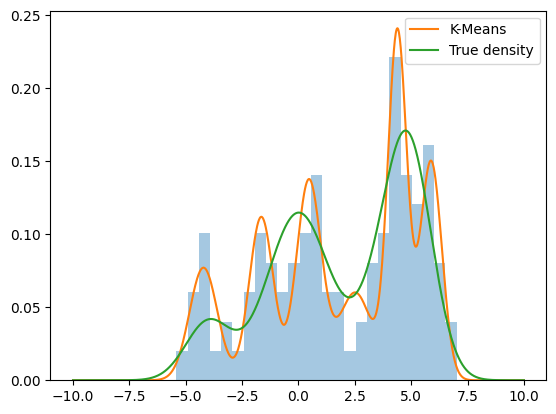

In [ ]:
nclases = 6

kmeans = KMeans(nclases)
kmeans.fit(data)

y_kmeans = kmeans.predict(data)

means = kmeans.centroides.flatten()

vars = np.array([
    np.var(data[y_kmeans == k], ddof=1) if np.sum(y_kmeans == k) > 1 else 1.0
    for k in range(nclases)
])

cks = np.array([
    np.mean(y_kmeans == k) for k in range(nclases)
])

x = np.linspace(-10, 10, 1000)
pdf_km = mixture_pdf(x, cks, means, vars)

plt.figure()
plt.hist(data, bins=25, density=True, alpha=0.4)
plt.plot(x, pdf_km, label="K-Means")
plt.plot(x, pdf, label="True density")
plt.legend()
plt.show()



In [ ]:
import numpy as np

class EM:
    def __init__(self, n_components=4, cvg=1e-4, min_var=1e-3):
        self.n_components = n_components
        self.cvg = cvg
        self.min_var = min_var

        self.means = None
        self.vars = None   # varianzas escalares
        self.c = None      # pesos

    def gauss(self, X, mean, var):
        # X shape (N, 1), mean scalar, var scalar
        diff = X[:, 0] - mean
        return (1.0 / np.sqrt(2 * np.pi * var)) * np.exp(-(diff**2) / (2 * var))

    def fit(self, X):
        X = np.asarray(X)
        N, D = X.shape
        assert D == 1, "Este EM está hecho para datos de 1D."

        # --------- Inicialización con K-means ---------
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=self.n_components, n_init="auto")
        labels = kmeans.fit_predict(X)

        self.means = kmeans.cluster_centers_.flatten()
        self.vars = np.array([
            np.var(X[labels == k]) if np.sum(labels == k) > 1 else 1.0
            for k in range(self.n_components)
        ])
        self.vars = np.maximum(self.vars, self.min_var)

        self.c = np.ones(self.n_components) / self.n_components

        # --------- Iteraciones EM ---------
        log_ver = 10
        log_ver_old = 0

        while abs(log_ver - log_ver_old) > self.cvg:
            # ---- E-step ----
            q = np.zeros((N, self.n_components))
            for k in range(self.n_components):
                q[:, k] = self.c[k] * self.gauss(X, self.means[k], self.vars[k])

            q /= np.sum(q, axis=1, keepdims=True)

            # ---- M-step ----
            Nk = np.sum(q, axis=0)

            self.c = Nk / N
            self.means = (q.T @ X).flatten() / Nk

            self.vars = np.zeros(self.n_components)
            for k in range(self.n_components):
                diff = X[:, 0] - self.means[k]
                self.vars[k] = np.sum(q[:, k] * diff**2) / Nk[k]

            self.vars = np.maximum(self.vars, self.min_var)

            # ---- Log-verosimilitud ----
            log_ver_old = log_ver

            p = np.zeros((N, self.n_components))
            for k in range(self.n_components):
                p[:, k] = self.c[k] * self.gauss(X, self.means[k], self.vars[k])

            log_ver = np.sum(np.log(np.sum(p, axis=1)))

    def predict_proba(self, X):
        X = np.asarray(X)
        N = X.shape[0]
        p = np.zeros((N, self.n_components))
        for k in range(self.n_components):
            p[:, k] = self.c[k] * self.gauss(X, self.means[k], self.vars[k])
        return p

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


##EM

EM es mucho mas restrictivo entre clases y en general clasifica mejor que K-Means. Se observa que hay dos clases con una varianza muy pequeña, esto pasa ya que a estas clases pertenecen muy pocas muestras y por lo tanto la clase colapsa. En realidad, estas clases no existen ya que supusimos mal la cantidad de comportamientos.

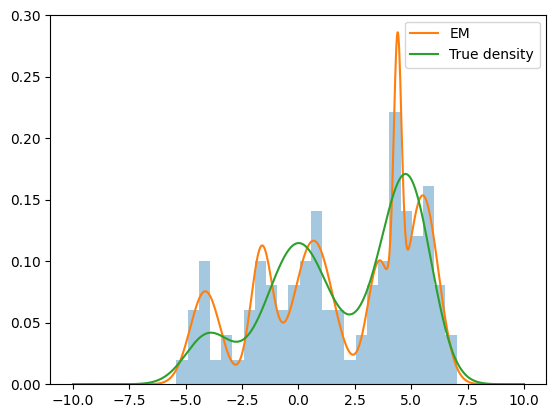

In [ ]:
em = EM(nclases)
em.fit(data)


means = em.means
vars = em.vars
#Inicializo los pesos
cks = em.c

x = np.linspace(-10, 10, 1000)

pdf_em = mixture_pdf(x, cks, means, vars)

plt.figure()
plt.hist(data, bins=25, density=True, alpha=0.4)
plt.plot(x,pdf_em, label="EM")
plt.plot(x, pdf, label="True density")
plt.legend()
plt.show()

In [ ]:
import numpy as np
from scipy.special import softmax, digamma, gamma


class VB:

    def __init__(self, K, max_iter=100, tol=1e-8):
        self.K = K #cant de clases
        self.max_iter = max_iter
        self.tol = tol

    def predict_proba(self, X):
        X = np.asarray(X)
        n = X.shape[0]

        log_pi = digamma(self.alpha) - digamma(np.sum(self.alpha))

        x_col = X[:, None]
        log_pdf = (
            digamma(self.nu / 2)
            - np.log(self.beta)
            - 1 / (2 * self.beta)
            - (self.nu / 2) * (x_col - self.m) ** 2
        )

        r = softmax(log_pi + log_pdf, axis=1)
        return r

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


    def fit(self, X):
        X = np.asarray(X)
        n = X.shape[0] #muestras

        #Inicializo con EM
        em = EM(self.K)
        em.fit(X)
        self.r = em.predict_proba(X)

        #Inicializo con los parámetros dichos
        self.alpha_0 = np.ones(self.K)
        self.delta_0 = 0.05
        self.nu_0 = 0.05
        self.beta_0 = 0.05
        self.m_0 = 0

        for _ in range(self.max_iter):

            #Actualizacion de parámetros a partir de los estadisticos
            Nk = np.sum(self.r, axis=0)
            fk = self.r.T @ X
            sk = self.r.T @ X**2

            self.alpha = self.alpha_0 + Nk

            self.delta = self.delta_0 + Nk

            self.nu = self.nu_0 + 0.5 * Nk

            self.m = np.zeros(self.K)
            self.beta = np.zeros(self.K)
            for k in range(self.K):
              num_m = self.delta_0 * self.m_0 + fk[k]
              den_m = self.delta_0 + Nk[k]
              self.m[k] = num_m / den_m

              num_beta = self.beta_0 + 0.5 * sk[k] + 0.5*self.delta_0*self.m_0**2
              num_beta -= (self.delta_0 * self.m_0 + fk[k]) ** 2 / (2 * (self.delta_0 + Nk[k]))
              self.beta[k] = num_beta


            #Calculo la proba de cada muestra de estar en cada clase
            #Hago con logaritmo por simplicidad
            log_r = np.zeros([n, self.K])
            for k in range(self.K):
              log_pi = digamma(self.alpha[k]) - digamma(np.sum(self.alpha))
              x_col = X[:, None]
              log_pdf = (
                  0.5*(digamma(self.nu[k] / 2)
                  - np.log(self.beta[k]))
                  - 1 / (2 * self.delta[k])
                  - (self.nu[k] / (2*self.beta[k])) * (X - self.m[k]) ** 2
              )

              log_r[:,k] = log_pi + log_pdf.reshape(-1)

            r_new = softmax(log_r, axis=1)
            #Chequeo convergencia
            if hasattr(self, "r"):
                if np.max(np.abs(r_new - self.r)) < self.tol:
                    break

            self.r = r_new

        return self

    def sample_posterior_params(self, n_samples=3):
      samples = []

      alpha = self.alpha
      nu    = self.nu
      delta = self.delta
      beta  = self.beta
      m     = self.m

      for _ in range(n_samples):
          #Pi es una dirichlett con parametros alpha
          pi = np.random.dirichlet(alpha.reshape(-1))

          mus = np.zeros(self.K)
          lambdas = np.zeros(self.K)

          for k in range(self.K):
              #Las lambda son gammas(nu, beta) (invierto beta por como es la funcion de numpy)
              lam = np.random.gamma(nu[k], 1/beta[k])
              lambdas[k] = lam

              #Las medias son normales de media m y var 1/delta*lambda
              var_mu = 1 / (delta[k] * lam)
              mu = np.random.normal(m[k], np.sqrt(var_mu))
              mus[k] = mu

          samples.append((mus, lambdas, pi))

      return samples


    def predictive_pdf(self, x):
      p = 0
      for k in range(self.K):
        #Hago la predictiva con la t-student
        nu = 2*self.nu[k]
        Lambda = self.delta[k]*self.nu[k]/((self.delta[k] + 1)*self.beta[k])
        p += self.alpha[k]/np.sum(self.alpha) * gamma((nu + 1)/2)/gamma(nu/2) * np.sqrt(Lambda/(np.pi*nu)) * (1 + Lambda* (x - self.m[k])**2/nu) **(-(nu + 1)/2)
      return p


##Variational Bayes

Al usar VB estamos obteniendo una distribución de los datos planteando dsitribuciones a priori de estos y de los parámetros que determinan esa distribución. Esto da los suficientes grados de libertad como para que el modelo pueda adaptarse a los datos de una manera suficientemente general a pesar de la baja cantidad. Al mismo tiempo, gracias a esta flexibilidad, logra apagar las clases que realmente no son parte de la distribución.


El algoritmo se inicializa con un EM, que da una distribución de probabilidades inicial $r_{i,k}$ donde $i$ son las muestras y $k$ las clases. A partir de ahí el algoritmo tiene dos pasos.

Uno donde actualiza los parámetros basándose en las distribuciones a posteriori. Esto lo hace a partir de los estadisticos

$$N_k = \sum_{i=1}^N r_{i,k} \qquad f_k = \sum_{i=1}^N r_{i,k}\,x_i \qquad s_k = \sum_{i=1}^N r_{i,k}\,x_i^2 $$

Así los parámetros quedan

$$
\alpha_k^* = \alpha_k + \sum_{i=1}^{n} r_{i,k},
\qquad
m_k^* = \frac{\delta m + \sum_{i=1}^{n} r_{i,k} x_i}{\delta + \sum_{i=1}^{n} r_{i,k}}
$$

$$
\delta_k^* = \delta + \sum_{i=1}^{n} r_{i,k},
\qquad
\nu_k^* = \nu + \frac{1}{2} \sum_{i=1}^{n} r_{i,k}
$$

$$
\beta_k^* = \beta + \frac{\delta m^2}{2} + \frac{1}{2} s_k - \frac{\left(\delta m + f_k\right)^2}{2\left(\delta + N_k\right)}
$$

Una vez con los parámetros a posteriori, pueden recalcularse las probabilidades

$$
\rho_{i,k} =
\exp \left(
\psi(\alpha_k^*) - \psi\left(\sum_{c=1}^{K} \alpha_c^*\right)
+ \frac{\psi(\nu_k^*) - \log(\beta_k^*)}{2}
- \frac{1}{2\delta_k^*}
- \frac{\nu_k^*}{2\beta_k^*} (m_k^* - x_i)^2
\right)
$$

y las probabilidades

$$r_{k,i} = \dfrac{\rho_{i,k}}{\sum_{c=1}^{K} \rho_{i,c}}$$

Para simplificar el computo puede calcularse directamente el logaritmo de las probabilidades y aplicarle softmax.




In [ ]:
vb = VB(nclases, max_iter=4)
vb.fit(data)


/tmp/ipython-input-2066898000.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.m[k] = num_m / den_m
/tmp/ipython-input-2066898000.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.beta[k] = num_beta


##Muestreo de parámetros

Una vez entrenado el modelo, se pueden muestrear los parámetros que forman la multinomial y estimar así una distribución. Sin embargo esto no es robusto ya que las incertidumbres son grandes.

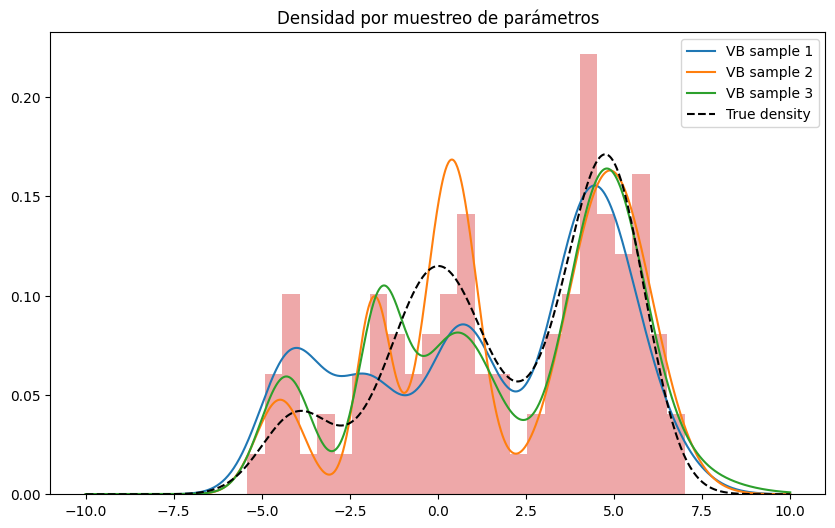

In [ ]:
samples = vb.sample_posterior_params(n_samples=3)

x = np.linspace(-10, 10, 1000)

plt.figure(figsize=(10,6))

# densidades de las muestras
for i,(mus,lams,pi) in enumerate(samples):
    pdf_vb = mixture_pdf(x, pi, mus, 1/lams)
    plt.plot(x, pdf_vb, label=f"VB sample {i+1}")


plt.plot(x, pdf, '--k', label="True density")
plt.hist(data, bins=25, density=True, alpha=0.4)

plt.legend()
plt.title("Densidad por muestreo de parámetros")
plt.show()



## Predictiva

Ya que se tiene la distribución a posteriori de los parámetros de la multinomial, una posibilidad es calcular la media de la distribución dada estas distribuciones a posteriori.

Haciendo es el cálculo queda

$$
p(x_{\text{test}} \mid \mathbf{x}) = \mathbb{E}[p(x_{\text{test}} \mid \phi) \mid \mathbf{x}]
= \sum_{k=1}^{K} \mathbb{E}[\pi_k \mid \mathbf{x}] \cdot
\mathbb{E}\left[
\left.
\frac{\sqrt{\lambda_k}}{\sqrt{2\pi}}
e^{-\frac{\lambda_k}{2}(x_{\text{test}} - \mu_k)^2}
\right| \mathbf{x}
\right]
= \sum_{k=1}^{K}
\frac{\alpha_k^*}{\sum_{c=1}^{K} \alpha_c^*}
\cdot \tilde{p}_k(x_{\text{test}} \mid \mathbf{x})
$$

Donde $\tilde{p}_k(x_{test}|\mathbf{x})$ sigue una distribución t-student

$$
p(x_{\text{test}} \mid \mathbf{x}) =
\sum_{k=1}^{K}
\frac{\alpha_k^*}{\sum_{c=1}^{K} \alpha_c^*}
\cdot
t\left(
x_{\text{test}}
\;\middle|\;
m_k^*,
\frac{\delta_k^* \nu_k^*}{(\delta_k^* + 1)\beta_k^*},
2\nu_k^*
\right)
$$





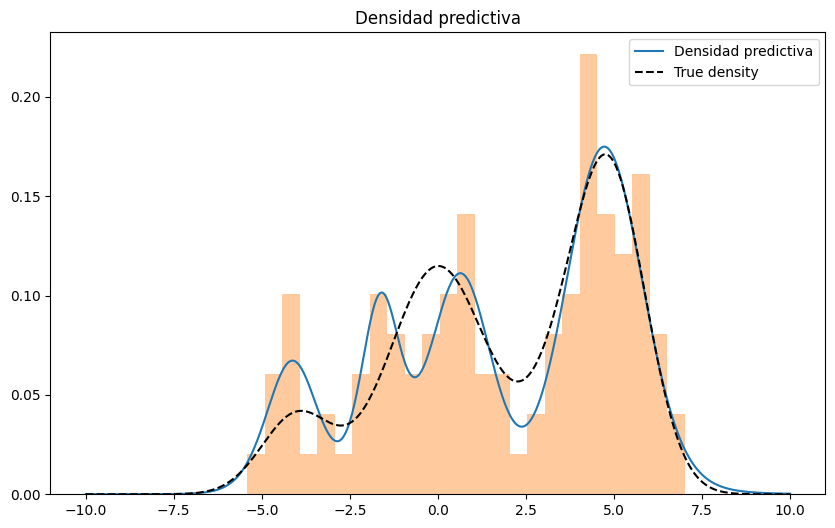

In [ ]:
x = np.linspace(-10, 10, 1000)

predictiva = vb.predictive_pdf(x)

plt.figure(figsize=(10,6))

plt.plot(x, predictiva, label = "Densidad predictiva")

plt.plot(x, pdf, '--k', label="True density")
plt.hist(data, bins=25, density=True, alpha=0.4)

plt.legend()
plt.title("Densidad predictiva")
plt.show()